In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.estela import spatial_gradient, mask_from_poly, Predictor
from teslakit.plotting.estela import Plot_ESTELA_Globe



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('GUAM')


In [3]:
# --------------------------------------
# load data and set parameters

ls_sea_poly = db.Load_ESTELA_coast()         # ESTELA coastline (land mask)
xds_est = db.Load_ESTELA_data()              # ESTELA D data
xds_WAVES = db.Load_ESTELA_waves()           # ESTELA gow waves point
print(xds_WAVES)
xds_SLP_site = db.Load_ESTELA_SLP()          # ESTELA Sea Level Pressure

xds_wvs_pts = db.Load_WAVES_partitions()     # waves partitions data

_, xds_TCs_r1_params = db.Load_TCs_r1()      # TCs historical parameters inside 14º radius 

# KMA REGRESSION GUIDED parameters
kma_date_ini = '1979-01-22'
kma_date_end = '2011-01-22'
num_clusters = 36
kmarg_alpha = 0.36

# waves point coordinates
pnt_lon = 144.5
pnt_lat = 13.5

<xarray.Dataset>
Dimensions:  (time: 111040)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2016-12-31T21:00:00
Data variables:
    hs       (time) float64 2.079 2.134 2.085 2.081 ... 2.159 2.091 2.032 1.932
    phs0     (time) float64 0.1441 0.19 0.168 0.1509 ... 0.1403 0.1241 0.1128
    phs1     (time) float64 1.716 1.368 1.278 1.313 ... 1.529 1.422 1.424 1.418
    phs2     (time) float64 1.139 1.182 1.2 1.244 1.165 ... 1.4 1.4 1.315 1.284
    phs3     (time) float64 0.2206 1.088 1.09 0.9852 ... 0.5605 0.5425 0.2379
    phs4     (time) float64 0.05664 0.2488 0.2187 0.22 ... 0.2324 0.228 0.05955
    phs5     (time) float64 0.05393 0.05729 0.06455 0.08161 ... nan 0.06576 nan
    tp       (time) float64 9.356 9.379 9.433 9.499 ... 9.645 9.404 9.335 9.435
    ptp0     (time) float64 3.213 2.962 4.8 4.335 ... 5.162 3.671 3.346 3.512
    ptp1     (time) float64 8.925 8.998 8.823 5.283 ... 6.021 7.148 9.383 9.521
    ptp2     (time) float64 9.989 5.583 5.285 9.333 ... 9.649 


## ESTELA Predictor - Sea Level Pressure and Gradient

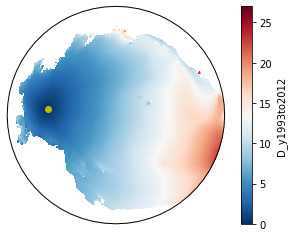

In [4]:
# --------------------------------------
# Plot ESTELA 

estela_D = xds_est.D_y1993to2012

# plot estela days-mask and wave point coordinates
Plot_ESTELA_Globe(pnt_lon, pnt_lat, estela_D)


In [5]:
# --------------------------------------
# ESTELA waves data: calculate Fe, resample to daily

# calculate Fe
hs = xds_WAVES.hs
tm = xds_WAVES.t02
Fe = np.multiply(hs**2,tm)**(1.0/3)
xds_WAVES.update({
    'Fe':(('time',), Fe)
})

# select time window and calculate daily mean
xds_WAVES = xds_WAVES.sel(
    time = slice(kma_date_ini, kma_date_end)
).resample(time='1D').mean()

print(xds_WAVES)


AttributeError: 'Dataset' object has no attribute 't02'

In [ ]:
# --------------------------------------
# Calculate site SLP & SLP_gradient (daily)

# select time window and do data daily mean
xds_SLP_day = xds_SLP_site.sel(
    time = slice(kma_date_ini, kma_date_end)
).resample(time='1D').mean()

# calculate daily gradients
xds_SLP_day = spatial_gradient(xds_SLP_day, 'SLP')

# use coastline polygons to generate a land mask
xds_SLP_day = mask_from_poly(xds_SLP_day, ls_sea_poly, 'mask_land')
    

In [ ]:
# --------------------------------------
# Select site ESTELA and generate ESTELA land mask

# select ESTELA at site grid
xds_est_site = xds_est.sel(
    longitude = xds_SLP_site.longitude,
    latitude = xds_SLP_site.latitude,
)
estela_D = xds_est_site.D_y1993to2012

# use ESTELA to generate ESTELA mask
mask_est = np.zeros(estela_D.shape)
mask_est[np.where(estela_D<1000000000)]=1

xds_SLP_day.update({'mask_estela':(('latitude','longitude'), mask_est)})

print(xds_SLP_day)



## ESTELA Predictor - Principal Component Analysis

In [ ]:
# --------------------------------------
# Calculate ESTELA PCA

# Use our custom ESTELA Predictor 
pred = Predictor(db.paths.site.ESTELA.pred_slp)
pred.data = xds_SLP_day

# PCA (dynamic estela predictor)
pred.Calc_PCA_EstelaPred('SLP', estela_D)

print(pred.PCA)


In [ ]:
# plot PCA EOFs
n_EOFs = 3
pred.Plot_EOFs_EstelaPred(n_EOFs, show=True)



## ESTELA Predictor - KMeans Classification

In [ ]:
# Calculate KMA (regression guided with WAVES data)

# TODO: encontrar alpha optimo?
pred.Calc_KMA_regressionguided(
    num_clusters,
    xds_WAVES, ['hs','t02','Fe'],
    kmarg_alpha)

print(pred.KMA)


In [ ]:
# plot KMA clusters
pred.Plot_KMArg_clusters_datamean('SLP', show=True, mask_name='mask_estela')



## ESTELA Predictor - Add Historical TCs

In [ ]:
# --------------------------------------
# use historical storms-parameters inside r1 to modify predictor KMA results 

storm_dates = xds_TCs_r1_params.dmin_date.values[:]
storm_categs = xds_TCs_r1_params.category.values[:]

# add r1 storms to predictor KMA
pred.Mod_KMA_AddStorms(storm_dates, storm_categs)

print(pred.KMA)


In [ ]:
# --------------------------------------
# Calculate intradaily MU TAU hydrographs

l_xds_MUTAU = pred.Calc_MU_TAU_Hydrographs(xds_wvs_pts)

# store hydrographs MU TAU
db.Save_MU_TAU_hydrograms(l_xds_MUTAU)

# TODO: plot report hydrographs